In [1]:
# %load 2comp_sed.py
#!/usr/bin/env python

### 1D sedimentation simulation

Solve a one-dimensional polydisperse sedimentation problem


$\phi_t + (f(\phi))_x = 0 $

Here $\phi$ is a vector of volume fractions $\in[0,1]$. f is a user-specified function
for the flux of particles.  
The variable state.q is the same as $\phi$. It follows the notation from Leveque's book "Finite Volume Methods for Hyperbolic Problems" 2001.

In [1]:
from __future__ import absolute_import
from clawpack import riemann
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# boundary conditions
def lowerwall(state,dim,t,qbc,auxbc,num_ghost):
    for i in range(num_ghost):
        qbc[:,i,...] = qbc[:,2*num_ghost-1-i,...]

def upperwall(state,dim,t,qbc,auxbc,num_ghost):
    for i in range(num_ghost):
        qbc[:,-i-1,...] = qbc[:,-2*num_ghost+i,...]
        

def lowerdirichlet(state,dim,t,qbc,auxbc,num_ghost):
    nspecies = qbc.shape[0]
    bvals = np.array([0.0,0.0])
    for i in range(num_ghost):
        qbc[:,i] = bvals

def upperdirichlet(state,dim,t,qbc,auxbc,num_ghost):
    nspecies = qbc.shape[0]
    bvals = np.array([0.,0.0])
    for i in range(num_ghost):
        qbc[:,-i-1] = bvals

In [3]:
def qinit(state,x0,u_rel,IC='dam-break'):
    xc = state.grid.x.centers

In [9]:
def runsim(qinit=None,num_output_times=10,tfinal=1,mx=51,IC='dam-break',
    use_petsc=False,kernel_language='Python',outdir='./_output',solver_type='classic'):

    if use_petsc:
        import clawpack.petclaw as pyclaw
    else:
        from clawpack import pyclaw

    if kernel_language == 'Python':
        rs = riemann.advection_nonlinear_1D_py.advection_nonlinear_fwave_1D
#         rs = riemann.advection_nonlinear_1D_py.advection_nonlinear_1D
    elif kernel_language == 'Fortran':
        print('No fortran solver available for advection_nonlinear_1D')
        pass

    if solver_type == 'classic':
        solver = pyclaw.ClawSolver1D(rs)
        solver.limiters = pyclaw.limiters.tvd.vanleer
    elif solver_type == 'sharpclaw':
        solver = pyclaw.SharpClawSolver1D(rs)

    solver.kernel_language = kernel_language
    solver.cfl_desired=0.25
    print('solver cfl',solver.cfl_desired)
    solver.order = 1
    print('solver order',solver.order)

    solver.bc_lower[0] = pyclaw.BC.custom
    solver.bc_upper[0] = pyclaw.BC.custom
    
    solver.user_bc_lower = lowerdirichlet
    solver.user_bc_upper = upperdirichlet

    xlower = 0.0
    xupper = 1.0
    mx = mx  # from kwargs
    x = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 2
    state = pyclaw.State(domain,num_eqn)

    # Gravitational constant
    state.problem_data['u_rel'] = np.array([1.,1/30.])
    state.problem_data['efix'] = False
    state.problem_data['basis'] = None

    xc = state.grid.x.centers
    print(xc)
    if IC=='uniform-all':
        c0 = np.array([0.6,0.0])
        # state defaults to empty. Convert to ones and fill with c0
        state.q = np.ones_like(state.q)*c0[:,np.newaxis]

    elif IC=='dam-break':
        # I changed state.is_valid() to always return true for fortran contiguity
        x0 = 0.2
        cr0 = np.array([0.4,0.1])
        cl0 = np.array([0.3,0.05])
        state.q = np.ones_like(state.q)
        state.q = cl0[:,np.newaxis]*(xc <= x0)[np.newaxis,:] + \
                  cr0[:,np.newaxis]*(xc >  x0)[np.newaxis,:]

    elif IC=='perturbation':
        x1 = 0.3
        x2 = 0.7
        eps = 0.5
        scale = 1.0
        state.q[0,:] = 0*scale*1/(np.sqrt(2*np.pi)*eps)*np.exp(-1/2*((xc-x1)/eps)**2)
#         state.q[0,-1] = 1.0
        state.q[1,:] = 1*scale*1/(np.sqrt(2*np.pi)*eps)*np.exp(-1/2*((xc-x2)/eps)**2)
    
    claw = pyclaw.Controller()
    claw.keep_copy = True
    claw.num_output_times = num_output_times
    claw.tfinal = tfinal
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.outdir = outdir
    print(state.problem_data)
    return claw

In [10]:
# %%capture
np.set_printoptions(precision=5,linewidth=np.inf)
ntimes = 20
mx = 6
tfinal = 6
claw = runsim(num_output_times=ntimes,tfinal=tfinal,mx=mx,
              IC='uniform-all')
claw.run()

solver cfl 0.25
solver order 1
[0.08333 0.25    0.41667 0.58333 0.75    0.91667]
{'u_rel': array([1.     , 0.03333]), 'efix': False, 'basis': None}
ascii
2019-03-27 09:28:27,313 INFO CLAW: Solution 0 computed for time t=0.000000
wave speed 
[[ 0.     0.    -0.224 -0.224 -0.224 -0.224 -0.224  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]]
 Q average                     Total net flux          right-moving flux           left-moving flux
[[ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.0384 -0.      0.0384  0.      0.      0.    ]
 [ 0.6     0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.6     0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.6     0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.6     0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.6     0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.     -0.0384  0.     -0.0384  0.      0.    

wave speed 
[[ 0.       0.      -0.24539 -0.224   -0.224   -0.224   -0.224    0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]]
 Q average                     Total net flux          right-moving flux           left-moving flux
[[ 0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.10015 -0.       0.10015  0.       0.       0.     ]
 [ 0.46176  0.      -0.06175  0.       0.       0.      -0.06175  0.     ]
 [ 0.6      0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.6      0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.6      0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.6      0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.      -0.0384   0.      -0.0384   0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.     ]]
wave speed 
[[ 0.      0.     -0.2393 -0.22

wave speed 
[[ 0.       0.      -0.07879 -0.224   -0.224   -0.224   -0.224    0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]]
 Q average                     Total net flux          right-moving flux           left-moving flux
[[ 0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.      -0.02358  0.      -0.02358  0.       0.       0.     ]
 [ 0.28896  0.       0.06198 -0.       0.       0.       0.06198  0.     ]
 [ 0.6      0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.6      0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.6      0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.6      0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.      -0.0384   0.      -0.0384   0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.     ]]
wave speed 
[[ 0.       0.      -0.03762 -0

wave speed 
[[ 0.       0.       0.28643 -0.24224 -0.224   -0.224   -0.224    0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]]
 Q average                     Total net flux          right-moving flux           left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  1.49941e-11  0.00000e+00  1.49941e-11  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.50720e-01  0.00000e+00  1.02757e-01 -0.00000e+00  1.02757e-01  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.50720e-01  0.00000e+00 -6.43571e-02  0.00000e+00  0.00000e+00  0.00000e+00 -6.43571e-02  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+

/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/riemann/advection_nonlinear_1D_py.py:96: RuntimeWarning: invalid value encountered in true_divide
  J  = (J1-J0)/dx



wave speed 
[[ 0.       0.       0.47408 -0.21796 -0.224   -0.224   -0.224    0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]]
 Q average                     Total net flux          right-moving flux           left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -1.42664e-14  0.00000e+00 -1.42664e-14  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.02772e-01  0.00000e+00  1.03066e-01 -0.00000e+00  1.03066e-01  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.02772e-01  0.00000e+00 -6.46658e-02  0.00000e+00  0.00000e+00  0.00000e+00 -6.46658e-02  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e

wave speed 
[[ 0.       0.       0.73726 -0.16549 -0.224   -0.224   -0.224    0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]]
 Q average                     Total net flux          right-moving flux           left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -2.75694e-16  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.70400e-02  0.00000e+00  6.99466e-02 -0.00000e+00  6.99466e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.47040e-01  0.00000e+00 -3.15466e-02  0.00000e+00  0.00000e+00  0.00000e+00 -3.15466e-02  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+

 Q average                     Total net flux          right-moving flux           left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -2.31065e-17  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.18175e-03  0.00000e+00  1.37534e-02  0.00000e+00  1.37534e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.07182e-01  0.00000e+00  2.46466e-02 -0.00000e+00  0.00000e+00  0.00000e+00  2.46466e-02  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -3.84000e-02  0.00000e+00 -3.84000e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.

value in q_ave < 0
wave speed 
[[ 0.       0.       1.13691 -0.05823 -0.224   -0.224   -0.224    0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]]
 Q average                     Total net flux          right-moving flux           left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -4.00966e-18  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-2.20800e-02  0.00000e+00 -5.02725e-02  0.00000e+00 -5.02725e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.77920e-01  0.00000e+00  8.86725e-02 -0.00000e+00  0.00000e+00  0.00000e+00  8.86725e-02  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.0

value in q_ave < 0
wave speed 
[[ 0.       0.       1.23691  0.00897 -0.23145 -0.224   -0.224    0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]]
 Q average                     Total net flux          right-moving flux           left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -6.23787e-19  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-3.73568e-02  0.00000e+00 -9.27422e-02  0.00000e+00 -9.27422e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.46055e-01  0.00000e+00  1.38815e-01 -0.00000e+00  1.38815e-01  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.83412e-01  0.00000e+00 -7.67252e-03  0.00000e+00  0.00000e+00  0.00000e+00 -7.67252e-03  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.0

{'cflmax': 0.29160709060525497,
 'dtmin': 0.03145306130575481,
 'dtmax': 0.18601190358446204,
 'numsteps': 68}

(6, 42)


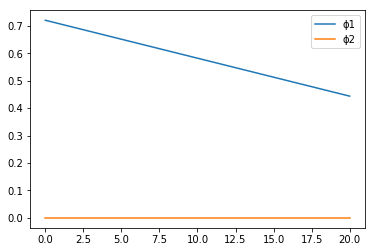

In [11]:
xs = np.linspace(0,1,mx)
dx = xs[1]-xs[0]

result = np.vstack([frame.q for frame in claw.frames]).T
print(result.shape)

plt.plot(np.sum(result[:,0::2],axis=0)*dx)
plt.plot(np.sum(result[:,1::2],axis=0)*dx)
plt.legend(['ϕ1','ϕ2'])

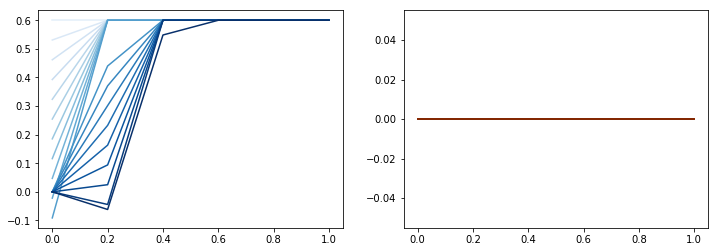

In [12]:
color1 = iter(plt.get_cmap('Blues')(np.linspace(0.1,1,ntimes)))
color2 = iter(plt.get_cmap('Oranges')(np.linspace(0.1,1,ntimes)))

fig,ax = plt.subplots(ncols=2,figsize=(12,4))
for j,color in enumerate((color1,color2)):
    for i in range(ntimes):
        ax[j].plot(xs,result[:,j+2*i],color=next(color))

2019-03-27 09:28:04,939 INFO CLAW: Animation.save using <class 'clawpack.visclaw.JSAnimation.html_writer.HTMLWriter'>



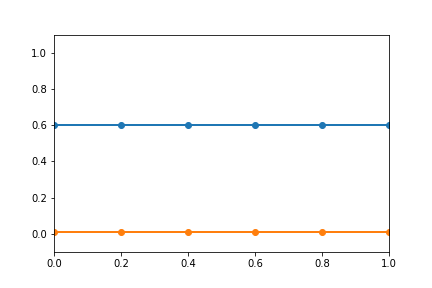
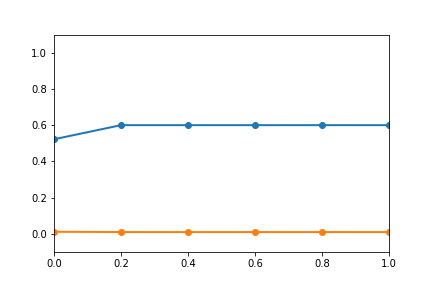
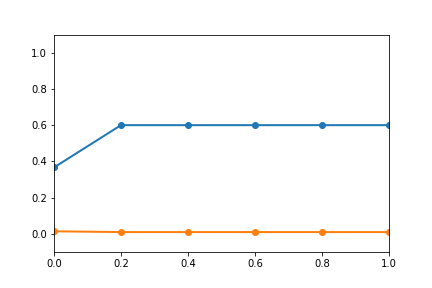
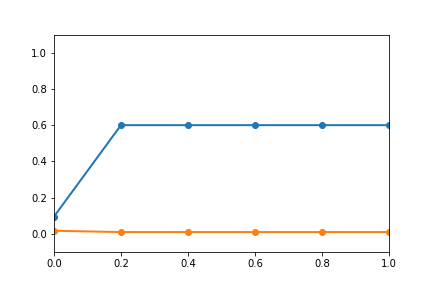
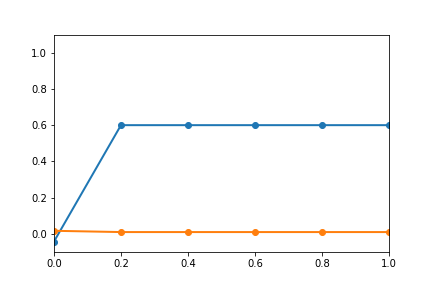
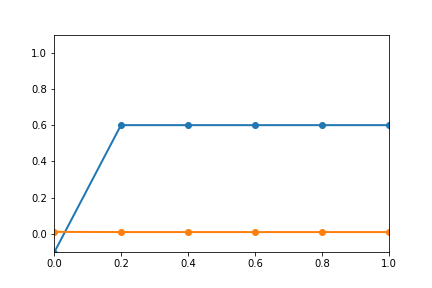
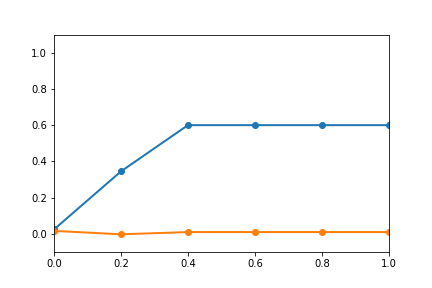
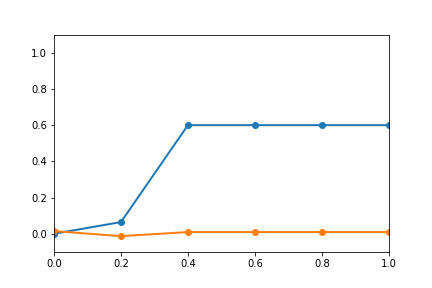

In [8]:
from matplotlib import animation
import matplotlib.pyplot as plt
from clawpack.visclaw.JSAnimation import IPython_display
import numpy as np

# x=domain.grid.x.centers
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.1, 1.1))

frame = claw.frames[0]
# species1 = frame.q[0,:]
line1, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], 'o-', lw=2)

def fplot(frame_number):
    frame = claw.frames[frame_number]
    species1 = frame.q[0,:]
    species2 = frame.q[1,:]
    line1.set_data(xs,species1)
    line2.set_data(xs,species2)
    return line1,line2

animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=250)